# Installing Dependencies

In [1]:
! pip install transformers

# Imports

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import backend
import matplotlib.pyplot as plt

# Dataset

### Function to read the image file

In [3]:
def load_image_file(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)

    image = tf.image.decode_jpeg(image, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    return {"image": image, "segmentation_mask": mask}

### Loading the dataset

In [4]:
train_image_dir = "/kaggle/input/landslide-divided/dataset/train/images"
train_mask_dir = "/kaggle/input/landslide-divided/dataset/train/masks"
valid_image_dir = "/kaggle/input/landslide-divided/dataset/validation/images"
valid_mask_dir = "/kaggle/input/landslide-divided/dataset/validation/masks"
test_image_dir = "/kaggle/input/landslide-divided/dataset/test/images"
test_mask_dir = "/kaggle/input/landslide-divided/dataset/test/masks"

# Define list of image and mask file names
train_image_names = sorted(os.listdir(train_image_dir))
train_mask_names = sorted(os.listdir(train_mask_dir))

valid_image_names = sorted(os.listdir(valid_image_dir))
valid_mask_names = sorted(os.listdir(valid_mask_dir))

test_image_names = sorted(os.listdir(test_image_dir))
test_mask_names = sorted(os.listdir(test_mask_dir))

train_pairs = []
for img_name in train_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in train_mask_names:
        train_pairs.append((os.path.join(train_image_dir, img_name), os.path.join(train_mask_dir, mask_name)))
        
valid_pairs = []
for img_name in valid_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in valid_mask_names:
        valid_pairs.append((os.path.join(valid_image_dir, img_name), os.path.join(valid_mask_dir, mask_name)))

test_pairs = []
for img_name in test_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in test_mask_names:
        test_pairs.append((os.path.join(test_image_dir, img_name), os.path.join(test_mask_dir, mask_name)))

# Load image and mask data from file paths
data_train = [load_image_file(image_path, mask_path) for image_path, mask_path in train_pairs]
data_valid = [load_image_file(image_path, mask_path) for image_path, mask_path in valid_pairs]
data_test = [load_image_file(image_path, mask_path) for image_path, mask_path in test_pairs]

len(data_train), len(data_valid), len(data_test)

(1385, 396, 199)

### Normalization and Image Resizing

#### P.S. You could do data augmentation here as well. I kept it very simple

In [5]:
image_size = 256
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask = input_mask / 255
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [6]:
train_data = [load_image(datapoint) for datapoint in data_train]
valid_data = [load_image(datapoint) for datapoint in data_valid]
test_data = [load_image(datapoint) for datapoint in data_test]

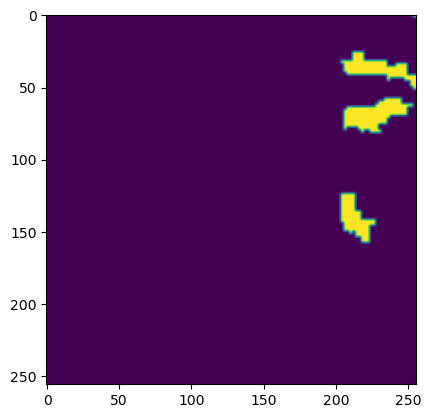

In [7]:
plt.imshow(train_data[0]["labels"])

In [8]:
def generator_train():
    for datapoint in train_data:
        yield datapoint
        
def generator_valid():
    for datapoint in valid_data:
        yield datapoint
        
def generator_test():
    for datapoint in test_data:
        yield datapoint

### Using <code>tf.data.Dataset</code> to build input pipeline

In [9]:
batch_size = 4
auto = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_generator(generator_train, output_types={"pixel_values": tf.float32, "labels": tf.int32}).cache().shuffle(batch_size * 10).batch(batch_size).prefetch(auto)
    
valid_ds = tf.data.Dataset.from_generator(generator_valid, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)
    
test_ds = tf.data.Dataset.from_generator(generator_test, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)

In [10]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'labels': TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)}


# Visualizing the data

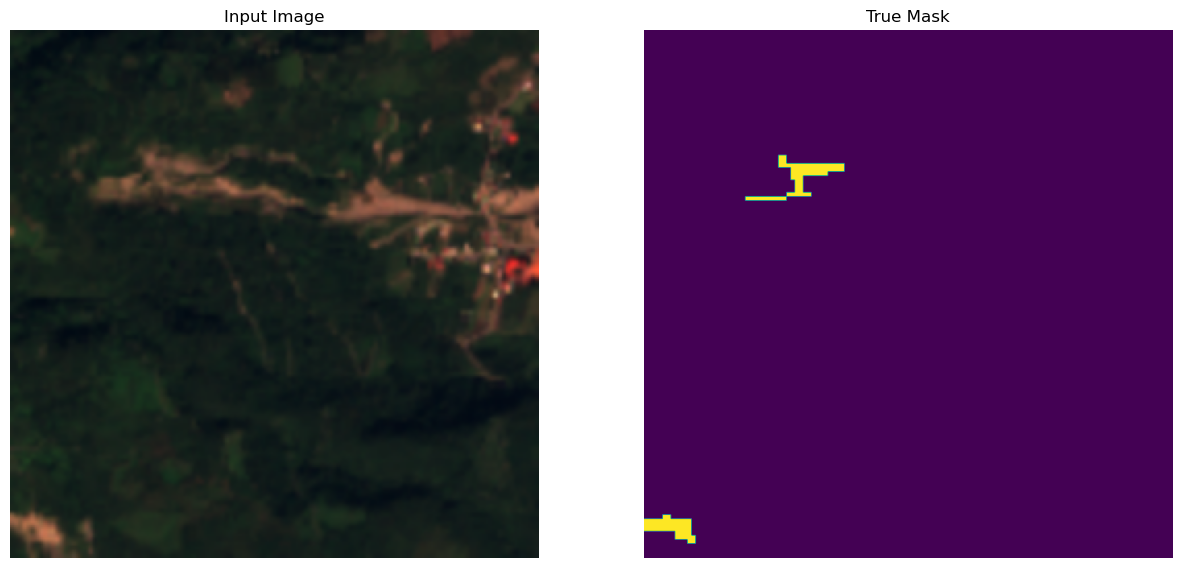

(256, 256, 3)


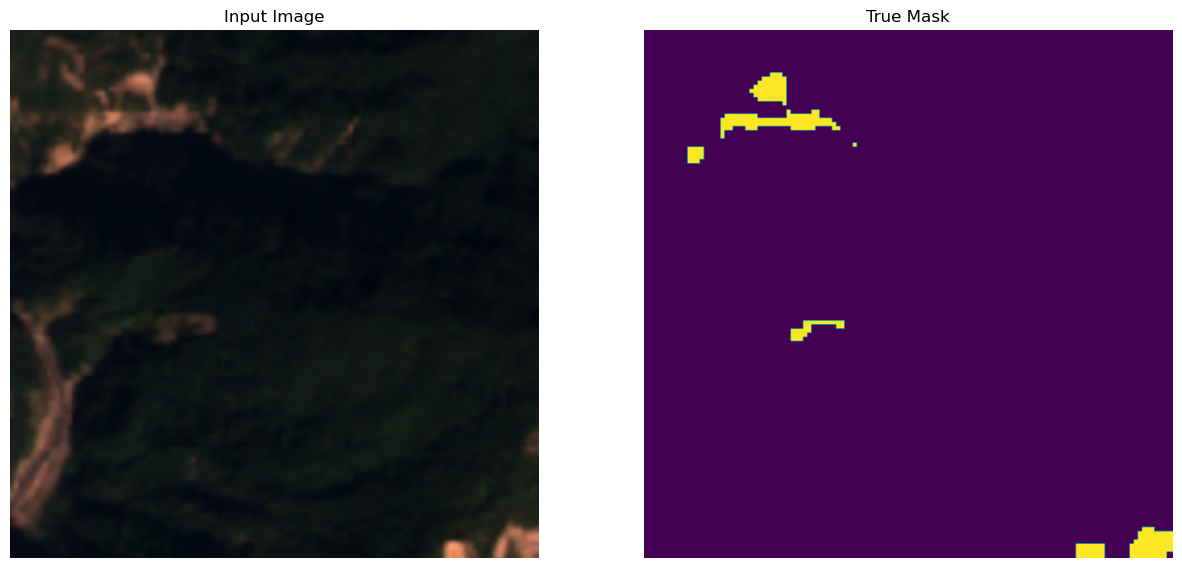

(256, 256, 3)


In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])
    print(sample_image.shape)

# Model

In [12]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b1"
id2label =  {0: "outer", 1: "landslide"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    
)

Some layers from the model checkpoint at nvidia/mit-b1 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Hyperparameters and compiling the model

In [13]:
lr = 0.00006
epochs = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


### Callback to visualize image after every epoch

In [14]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


# Training Loop

1/1 [==============================] - 0s 60ms/step


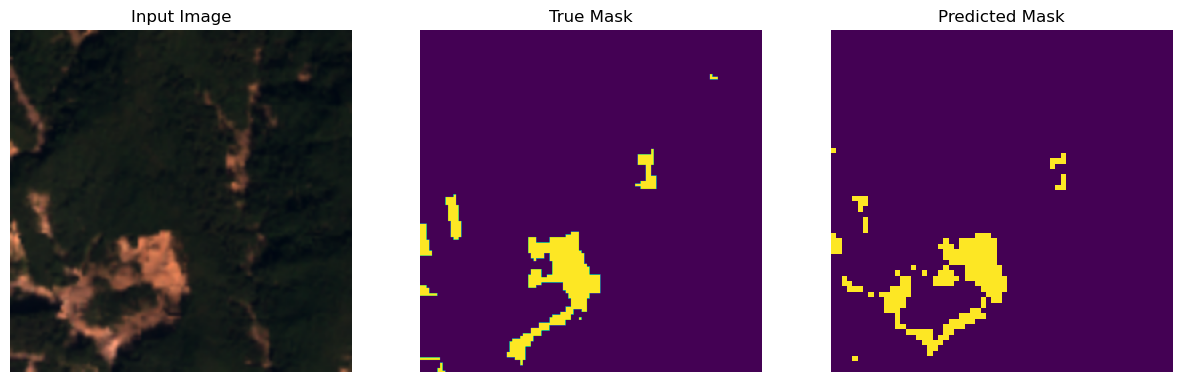


Sample Prediction after epoch 5

347/347 [==============================] - 40s 114ms/step - loss: 0.0638 - val_loss: 0.0524


In [15]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    callbacks=[DisplayCallback(test_ds)],
    epochs=epochs,
)

In [16]:
model.save_weights("/kaggle/working/segformer-5-b1.h5")

# Loss Plot

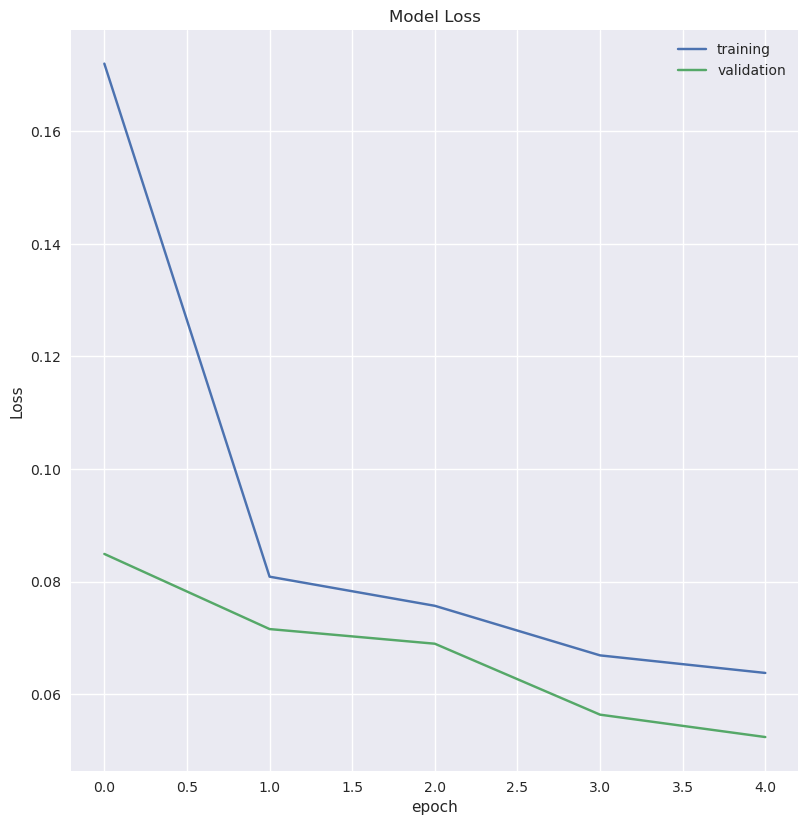

In [17]:
plt.style.use("seaborn")

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(8,8))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 111)
plt.savefig("train_eval_plot_segformer-5-b1.jpg")

# Predictions

1/1 [==============================] - 0s 102ms/step


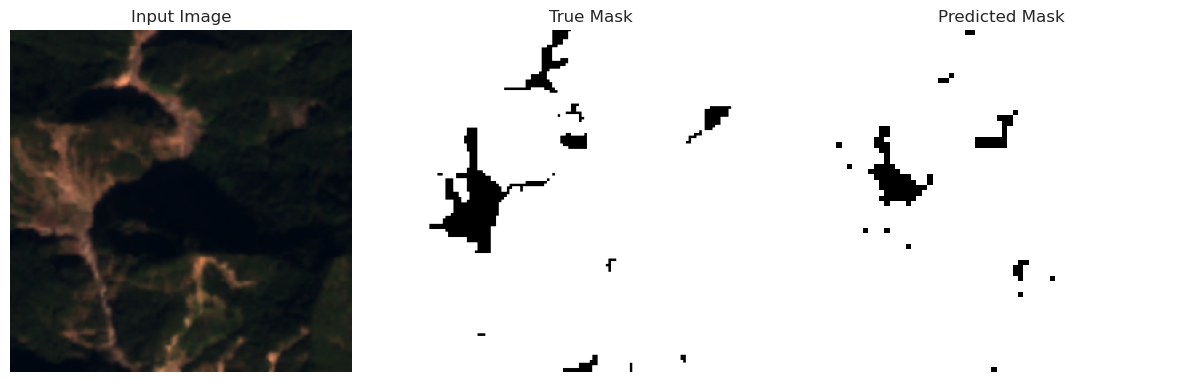

1/1 [==============================] - 0s 92ms/step


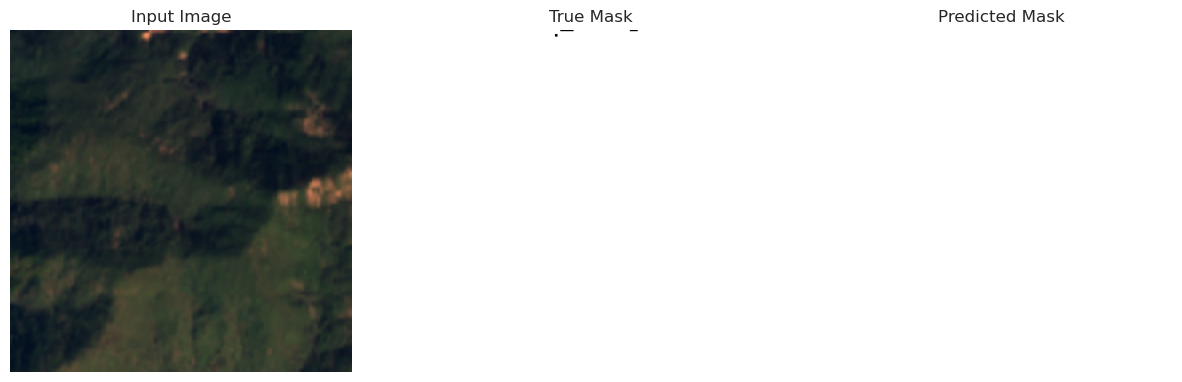

1/1 [==============================] - 0s 67ms/step


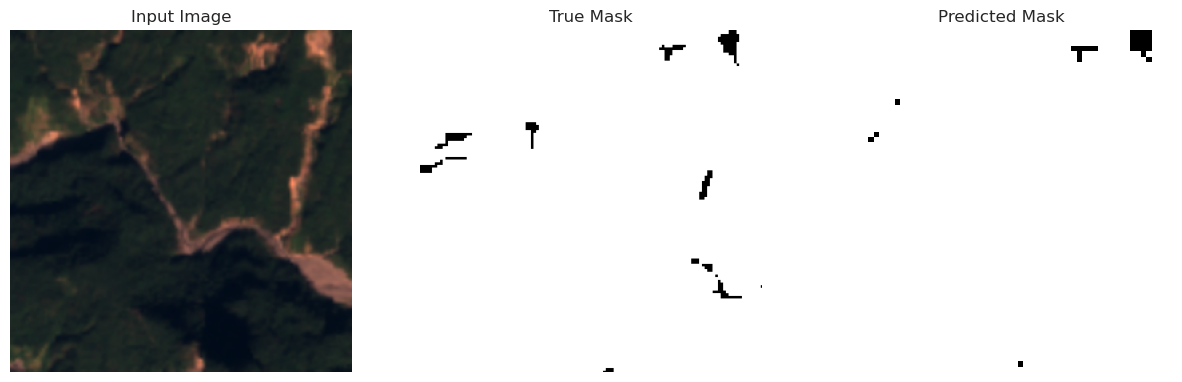

1/1 [==============================] - 0s 65ms/step


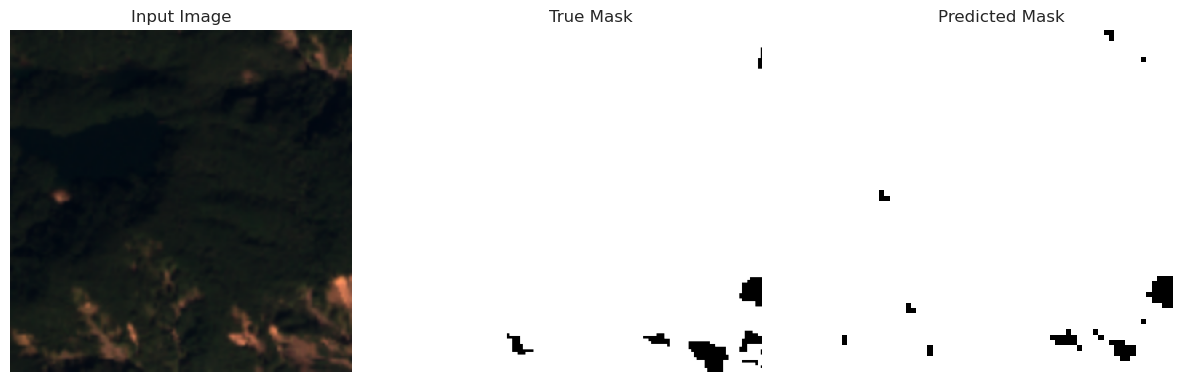

1/1 [==============================] - 0s 71ms/step


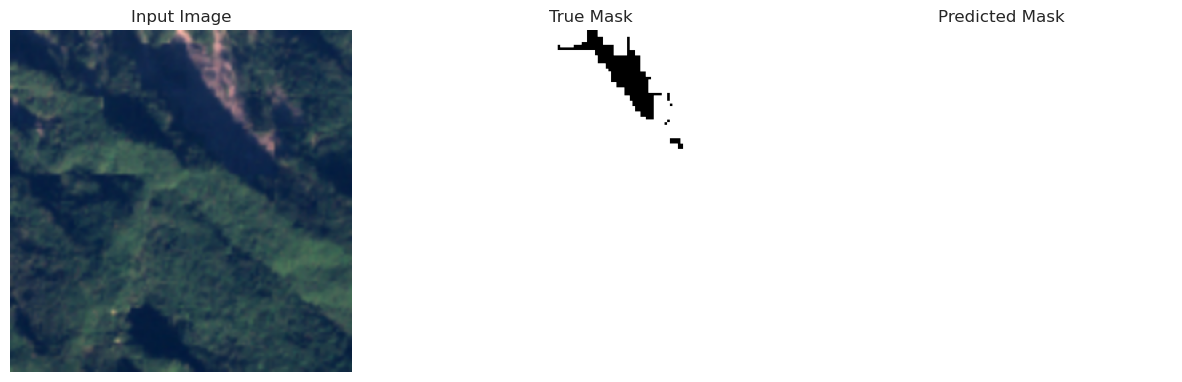

1/1 [==============================] - 0s 67ms/step


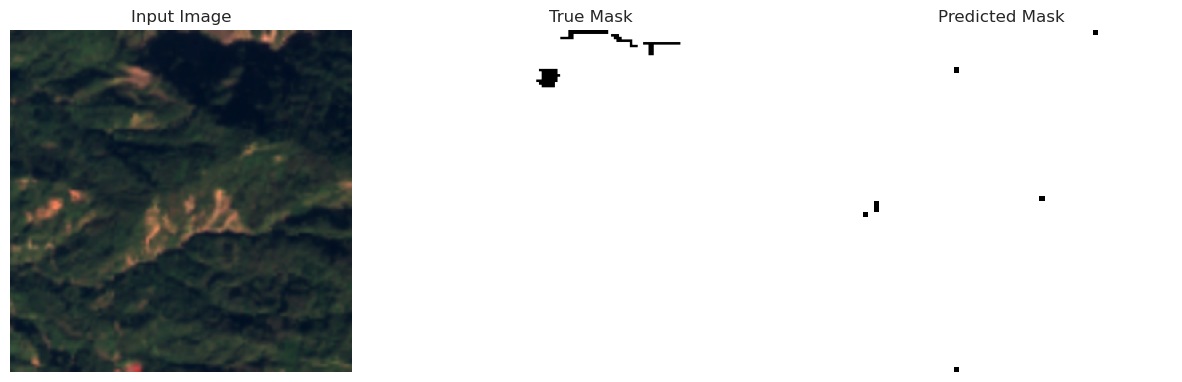

1/1 [==============================] - 0s 66ms/step


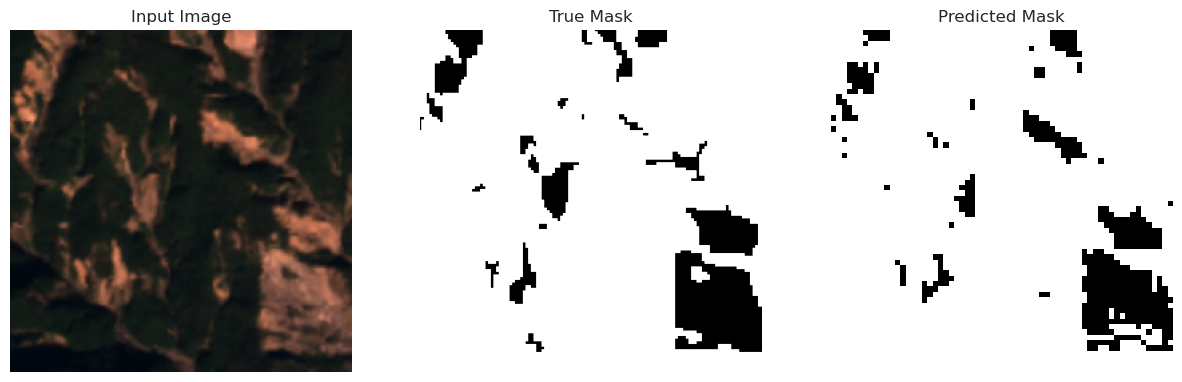

1/1 [==============================] - 0s 68ms/step


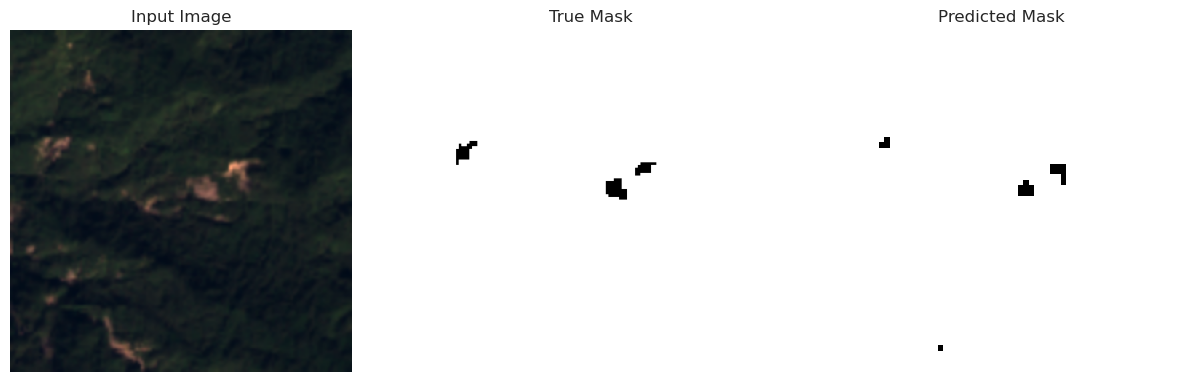

1/1 [==============================] - 0s 69ms/step


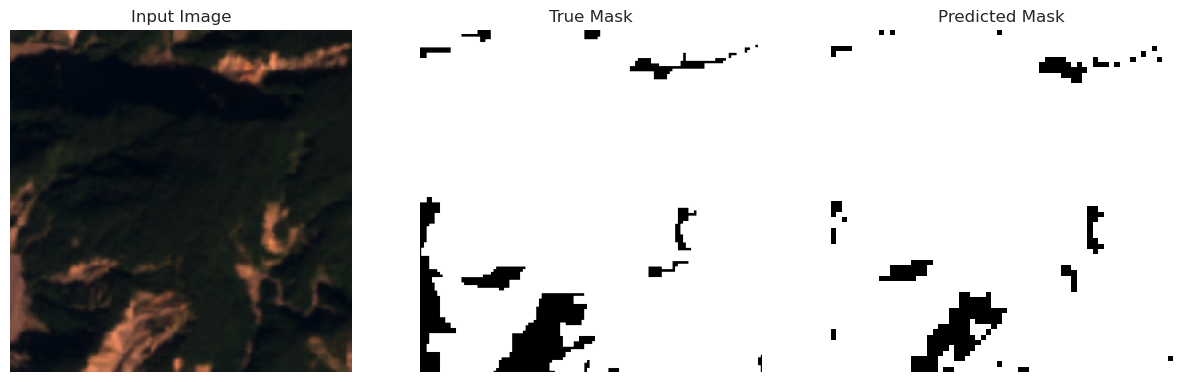

1/1 [==============================] - 0s 66ms/step


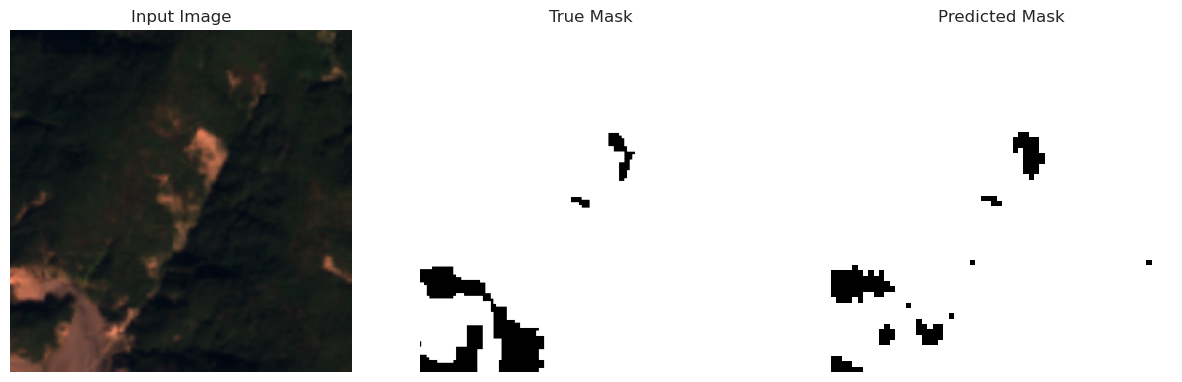

In [18]:
show_predictions(valid_ds, 10)